In [ ]:
# import needed packages
import pandas as pd
import numpy as np
import copy

#pd.options.mode.copy_on_write = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import os
import glob

#function that makes a copy of a dataset X but imposes the CP transform
#X=df[['lep_eta','lep_phi','gam_eta','gam_phi', 'met_phi','lep_pt_log','gam_pt_log','met_log','j0_pt_log']].values
def apply_cp_transform(X, y, isEFT):
    #make a copy of the dataset
    X_cp = copy.deepcopy(X)
    y_cp = copy.deepcopy(y)
    # transform the values in the first column of X to -1 times the value
    X_cp[:,2] = -1*X_cp[:,2]
    X_cp[:,3] = -1*X_cp[:,3]
    X_cp[:,4] = X_cp[:,4] + np.pi
    X_cp[X_cp[:,4] > np.pi,1] -=2*np.pi
    X_cp[:,5] = X_cp[:,5] + np.pi
    X_cp[X_cp[:,5] > np.pi,1] -=2*np.pi
    
    if isEFT:
        y_cp += 1.0
        y_cp[y_cp>1.5] = 0
    
    return X_cp, y_cp




In [40]:

#define path to input files when opening csv files
path='./csv/'
seed =314
k_fac=1.5
lumi=30000000
N_int=100000
sf_sm=k_fac
sf_int=k_fac*lumi/N_int

In [41]:
# define input name

file_list_sm=glob.glob(path+'fcc_ppllbb_sm_merged_10000.csv')
file_list_int=glob.glob(path+'fcc_ppllbb_chwtil_merged_10000.csv')


jetptcut=30.0
feature_names=['lepton1_pt','lepton2_pt','lepton1_eta','lepton2_eta', 'lepton1_phi', 'lepton2_phi']
write_classifier = False
apply_scaler = True

tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()


In [ ]:
# import interference data
df = pd.read_csv('fcc_ppllbb_chwtil_100000.csv')
print(df.columns)

#create the input variables (X) and the target (y) for the interference sampl
X=df[feature_names].values
print(X)
y = df['event_weight'].values
w = copy.deepcopy(y)
y[y<0]=0
y[y>0]=1
#calculate the sum of the weights for the interference sample
sum_w_int = np.sum(w)
sum_w_err_int = np.sqrt(np.sum(w**2))

#make a CP transform of the inteference sample
X_cp, y_cp = apply_cp_transform(X, y,True)

# import SM data and scale it and create the input variables (X) and the target (y) for the SM sample
df_sm = pd.read_csv('fcc_ppllbb_sm_merged_10000.csv')
print(df_sm.columns)

X_sm = df_sm[feature_names].values
y_sm = df_sm['event_weight'].values
w_sm = copy.deepcopy(y_sm)
y_sm[:]=2 
sum_w_sm = np.sum(w_sm)
sum_w_err_sm = np.sqrt(np.sum(w_sm**2))

X_sm_cp, y_sm_cp = apply_cp_transform(X_sm,y_sm,False)
w_sm_cp = copy.deepcopy(w_sm)
print(sum_w_sm)
#the sf below accounts for NLO virtual corrections when making predictions 
#sf=1.2*143000/sum_w_sm

#combine the interference and SM samples for multiclass classification, as well as the CP-transformed datasets
#X_tot=np.concatenate((X,X_cp,X_sm,X_sm_cp))
#y_tot=np.concatenate((y,y_cp,y_sm, y_sm_cp))
X_tot=np.concatenate((X,X_sm))
y_tot=np.concatenate((y,y_sm))
y_tot = tf.keras.utils.to_categorical(y_tot, num_classes=3)
#X_tot=X
#y_tot=y
#y_tot = tf.keras.utils.to_categorical(y_tot, num_classes=2)



if(apply_scaler):
    scaler = MinMaxScaler()
    X_tot = scaler.fit_transform(X_tot)
    X = scaler.transform(X)
    X_sm = scaler.transform(X_sm)




Index(['event_number', 'bjet1_pt', 'bjet2_pt', 'lepton1_pt', 'lepton2_pt',
       'bjet1_eta', 'bjet2_eta', 'lepton1_eta', 'lepton2_eta', 'bjet1_phi',
       'bjet2_phi', 'lepton1_phi', 'lepton2_phi', 'bjet1_mass', 'bjet2_mass',
       'lepton1_mass', 'lepton2_mass', 'lepton1_charge', 'lepton2_charge',
       'event_weight'],
      dtype='object')
[[ 8.08363950e+01  8.03441540e+01  2.19443400e+00  1.32268900e+00
   2.53620600e+00  3.13328300e+00]
 [ 1.40284363e+02  1.07384628e+02 -1.85510000e-02 -1.08795000e-01
   2.94915700e+00 -2.59362600e+00]
 [ 1.21636871e+02  7.00574260e+01  6.63573000e-01  4.87510000e-01
   4.16514000e-01 -6.04279000e-01]
 ...
 [ 1.04132828e+02  9.65038450e+01 -2.99649000e-01 -4.43310000e-02
   2.44676300e+00  1.51687200e+00]
 [ 1.27592033e+02  9.33260650e+01  6.70588000e-01  4.15268000e-01
  -2.31928900e+00 -1.53597700e+00]
 [ 2.83729462e+02  5.72997280e+01 -8.85490000e-02  2.27391000e-01
  -2.33754000e-01 -8.97822000e-01]]
Index(['event_number', 'bjet1_pt', 'bj

In [43]:
# split data to train/val/test, this is for binary classification
split=0.5
X_train, X_2, y_train, y_2   = train_test_split(X_tot,   y_tot,   test_size=split, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_2, y_2, test_size=split, random_state=101)



In [44]:
# check that classes are balanced
y_dict={'y_train':y_train, 'y_val':y_val, 'y_test':y_test}
for key,val in y_dict.items():
    print(f'{key} :')
    print(f'\tclass 0 = {100.*(val[:,0]).sum()/len(val):.1f}%')
    

y_train :
	class 0 = 35.3%
y_val :
	class 0 = 36.0%
y_test :
	class 0 = 36.2%


In [45]:
# define the classifier and train it
#classifier = MLPClassifier(hidden_layer_sizes=(100,50,20), max_iter=1000,activation = 'relu',solver='adam',random_state=1,batch_size=5000)
#classifier.fit(X_train, y_train)

# Create a Keras model, worry about input shape?
classifier = Sequential()
classifier.add(Input(shape=(len(feature_names),)))
classifier.add(Dense(100, activation='relu'))
classifier.add(Dense(50, activation='relu'))
classifier.add(Dense(20, activation='relu'))
classifier.add(Dense(3, activation='softmax'))
#classifier.add(Dense(2, activation='softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
#build a classifier with cross entropy loss for multiclass classification

#classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                    loss='categorical_crossentropy',
#                    metrics=[keras.metrics.CategoricalAccuracy()])
                    #loss='sparse_categorical_crossentropy',
                    #metrics=['accuracy'])
print(classifier.summary())



#classifier.build(input_shape=(0,X_train.shape[1]))

# Create a History object to track the validation loss
history = History()
min_delta = 0.000
patience = 10
epochs = 1000
batch_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=min_delta, patience=patience, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

# Train the model
classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[history,early_stopping], batch_size=batch_size)
#128 batch size, patience of 5, batch size in hundreds
#add batch size and learning rate to the fit statement


#Train the model with a fixed initial random seed






Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               700       
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 20)                1020      
                                                                 
 dense_15 (Dense)            (None, 3)                 63        
                                                                 
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
133/133 [==============================] - 0s 1ms/step - loss: 1.0933 - accuracy: 0.3486 - val_loss: 1.0916 - val_accuracy: 0.3743
Epoch 2/1000
133/133 [=============

In [46]:
#write the classifier model as a .h5 file

if(write_classifier):
    classifier.save_weights('model/'+eft_operator+'_classifier_tf.h5')
    model_json = classifier.to_json()
    with open('model/'+eft_operator+'_model_architecture.json', 'w') as json_file:
        json_file.write(model_json)

print('Features')
print(feature_names)
print('Offset')
print(-1*scaler.data_min_)
print('Scale')
print(scaler.scale_)
#print(scaler.min_)

Features
['lepton1_pt', 'lepton2_pt', 'lepton1_eta', 'lepton2_eta', 'lepton1_phi', 'lepton2_phi']
Offset
[-42.800304 -27.002026   2.688758   2.69952    3.141503   3.141171]
Scale
[0.0006989  0.00179344 0.18565241 0.18529269 0.15915723 0.15916729]


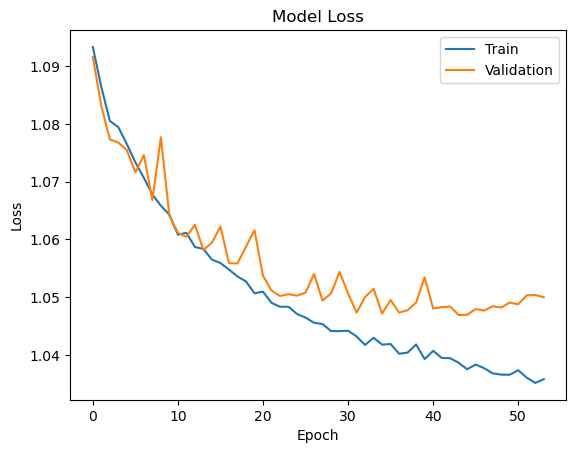

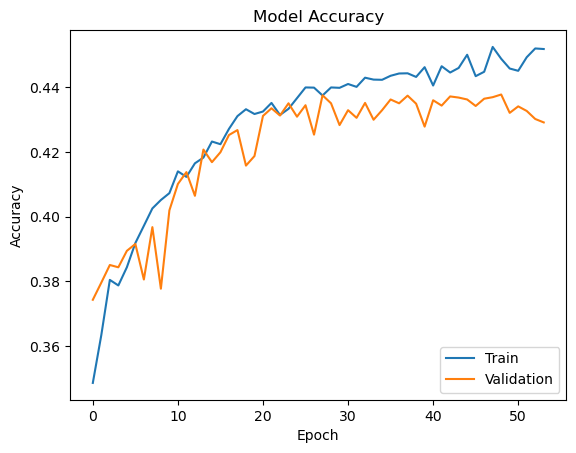

265/265 [==============================] - 0s 329us/step


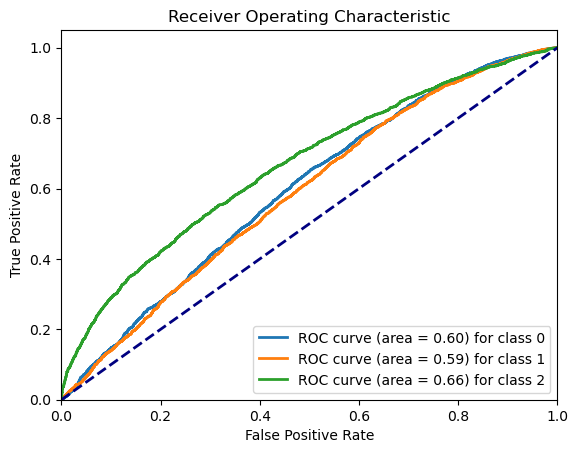

In [47]:
#plot the loss against the validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.savefig('plots/'+eft_operator+'_loss.png')
plt.show()

#plot the accuracy against the validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.savefig('plots/'+eft_operator+'_accuracy.png')
plt.show()

#plot the ROC curve
y_pred = classifier.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
lw = 2
#plot roc curves for each output node
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('plots/'+eft_operator+'_roc.png')
plt.show()


In [48]:
pred_sm = classifier.predict(X_sm)
pred_int = classifier.predict(X)



750/750 [==============================] - 0s 307us/step


299.6238835341405


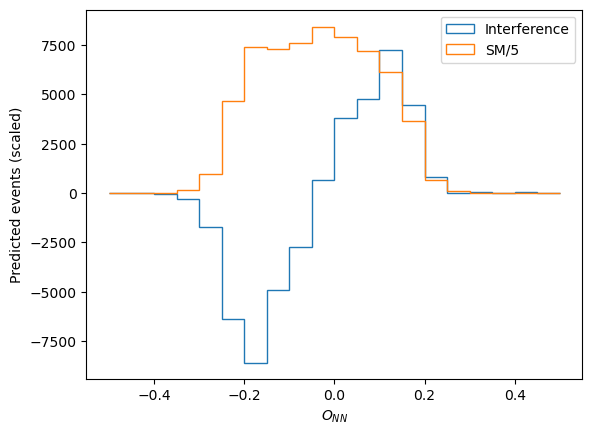

In [49]:
#wow, I've got to O_NN already!
onn_int = pred_int[:, 1]  - pred_int[:, 0]
onn_sm = pred_sm[:, 1]  - pred_sm[:, 0]

# define a mask for onn_int for pred_int[:,2]<0.5
mask = pred_int[:,0]<1.0
onn_int = onn_int[mask]
wi = w[mask]
#mask_sm = pred_sm[:,2]<1.0
#onn_sm = onn_sm[mask_sm]
#wi_sm = w_sm[mask_sm]
sf=1
bins=20

plt.hist(onn_int,weights=w*sf_int,histtype='step',bins=bins,range=(-0.5,0.5))
plt.hist(onn_sm,weights=w_sm*sf_sm/5,histtype='step',bins=bins,range=(-0.5,0.5))
#plt.hist(onn_sm_cp,weights=w_sm_cp*sf/50,histtype='step',bins=20,range=(-1,1))
#extract the y values of the histogram
n_int, x_int = np.histogram(onn_int,weights=w*sf_int,bins=bins,range=(-0.5,0.5))
n_sm, x_sm = np.histogram(onn_sm,weights=w_sm*sf_sm,bins=bins,range=(-0.5,0.5))

#calculate the sum of absolute n_int
abs_sum_n_int = np.sum(np.abs(n_int))

#arbitrary eft scaling: 
ci=0.25
chi2=0
for i in range(bins):
    if(n_sm[i]>25):
        chi2+=(ci*n_int[i])**2/(2*n_sm[i])
        #factor of two in denominator to account for backgrounds
print(chi2)

plt.xlabel('$O_{NN}$')
plt.ylabel('Predicted events (scaled)')
plt.legend(['Interference','SM/5'])

#save the figure as a pdf
plt.show()






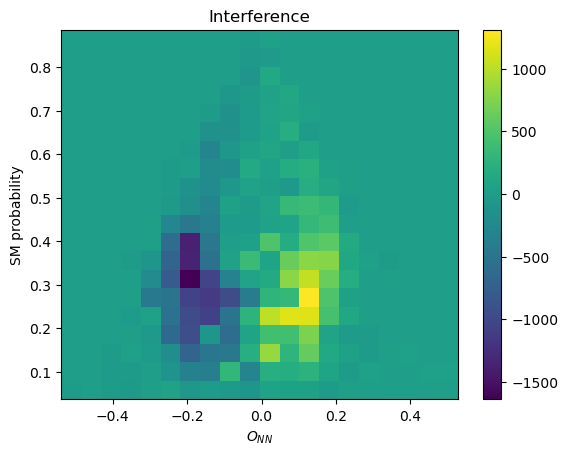

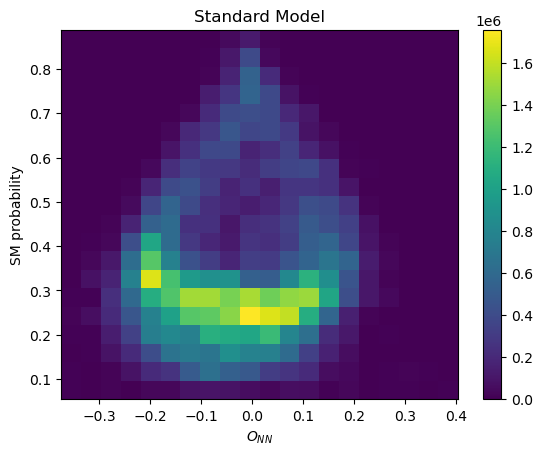

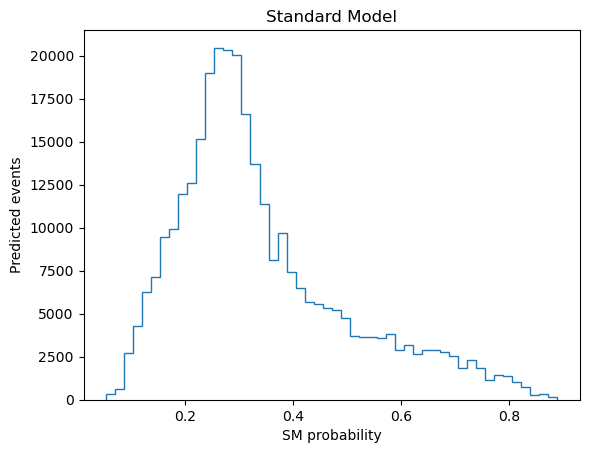

In [50]:
#make a 2D weighted histogram of pred_int[:,1]-pred_int[:,0] vs pred_int[:,2]
plt.hist2d(pred_int[:,1]-pred_int[:,0],pred_int[:,2],weights=w*sf_int,bins=20)
plt.title('Interference')
plt.xlabel('$O_{NN}$')
plt.ylabel('SM probability')
#add a colorbar to the plot
plt.colorbar()
#plt.savefig('plots/'+eft_operator+'_interference2D.png')
plt.show()
#same plot but for the SM on a log scale
plt.hist2d(pred_sm[:,1]-pred_sm[:,0],pred_sm[:,2],weights=w_sm*sf_int,bins=20)
plt.title('Standard Model')
plt.xlabel('$O_{NN}$')
plt.ylabel('SM probability')
plt.colorbar()
#plt.savefig('plots/'+eft_operator+'_SM2D.png')
plt.show()

#plot the yield as a function of pred_sm[:,2]
plt.hist(pred_sm[:,2],weights=w_sm*sf_sm,bins=50, histtype='step')
plt.xlabel('SM probability')
plt.ylabel('Predicted events')
plt.title('Standard Model')
#plt.savefig('plots/'+eft_operator+'_pSM.png')
plt.show()


In [51]:
#plot the ONN for the training and test samples

onn_train = classifier.predict(X_train)[:,1] - classifier.predict(X_train)[:,0]
onn_val = classifier.predict(X_val)[:,1] - classifier.predict(X_val)[:,0]



265/265 [==============================] - 0s 358us/step


/var/folders/pb/lx3s1x193tq3dythvw5qzqjh0000gn/T/ipykernel_43182/1839033121.py:33: RuntimeWarning: invalid value encountered in divide
  ratio=n_val_int/n_train_int
/var/folders/pb/lx3s1x193tq3dythvw5qzqjh0000gn/T/ipykernel_43182/1839033121.py:34: RuntimeWarning: divide by zero encountered in divide
  err_ratio=np.abs(ratio)*np.sqrt((n_val_int_err/n_val_int)**2+(n_train_int_err/n_train_int)**2)
/var/folders/pb/lx3s1x193tq3dythvw5qzqjh0000gn/T/ipykernel_43182/1839033121.py:34: RuntimeWarning: invalid value encountered in divide
  err_ratio=np.abs(ratio)*np.sqrt((n_val_int_err/n_val_int)**2+(n_train_int_err/n_train_int)**2)
/var/folders/pb/lx3s1x193tq3dythvw5qzqjh0000gn/T/ipykernel_43182/1839033121.py:34: RuntimeWarning: invalid value encountered in multiply
  err_ratio=np.abs(ratio)*np.sqrt((n_val_int_err/n_val_int)**2+(n_train_int_err/n_train_int)**2)


NameError: name 'eft_operator' is not defined

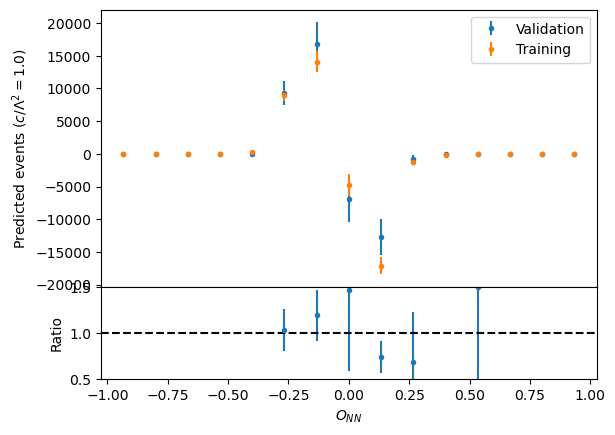

In [52]:
#apply mask to onn values to select only negative or positive events
mask_train_neg = (y_train[:,0]==1)
mask_train_pos = (y_train[:,1]==1)  
onn_train_neg = onn_train[mask_train_neg]
onn_train_pos = onn_train[mask_train_pos]
mask_val_neg = (y_val[:,0]==1) 
mask_val_pos = (y_val[:,1]==1)
onn_val_neg = onn_val[mask_val_neg]
onn_val_pos = onn_val[mask_val_pos]

n_train_neg, x_train_neg = np.histogram(onn_train_neg,weights=y_train[mask_train_neg,0],bins=15,range=(-1,1))
n_val_neg, x_val_neg = np.histogram(onn_val_neg,weights=y_val[mask_val_neg,0],bins=15,range=(-1,1))
n_train_pos, x_train_pos = np.histogram(onn_train_pos,weights=y_train[mask_train_pos,1],bins=15,range=(-1,1))
n_val_pos, x_val_pos = np.histogram(onn_val_pos,weights=y_val[mask_val_pos,1],bins=15,range=(-1,1))
#y_val above is an issue

n_train_int=(n_train_neg-n_train_pos)/(1-split)
n_train_int_err=np.sqrt(n_train_neg+n_train_pos)/(1-split)
n_val_int=(n_val_neg-n_val_pos)/(split*(1-split))
n_val_int_err=np.sqrt(n_val_neg+n_val_pos)/(split*(1-split))

scaling_train = abs_sum_n_int/np.sum(np.abs(n_train_int))
scaling_val = abs_sum_n_int/np.sum(np.abs(n_val_int))
n_train_int*=scaling_train
n_train_int_err*=scaling_train
n_val_int*=scaling_val
n_val_int_err*=scaling_val

diff = n_train_int-n_val_int
err = np.sqrt(n_train_int_err**2+n_val_int_err**2)


ratio=n_val_int/n_train_int
err_ratio=np.abs(ratio)*np.sqrt((n_val_int_err/n_val_int)**2+(n_train_int_err/n_train_int)**2)


#fix the above plots so that the relative difference is in a panel below the main plot
fig, ax = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios': [3, 1]})
ax[0].errorbar((x_val_neg[:-1]+x_val_neg[1:])/2,n_val_int, yerr=n_val_int_err , fmt='.')
ax[0].errorbar((x_train_neg[:-1]+x_train_neg[1:])/2,n_train_int, yerr=n_train_int_err , fmt='.')
ax[0].set_ylabel('Predicted events ($c/\Lambda^2=1.0$)')
ax[0].legend(['Validation','Training'])
ax[1].errorbar((x_val_neg[:-1]+x_val_neg[1:])/2,ratio,yerr=err_ratio,fmt='.')
ax[1].axhline(1,color='black',linestyle='--')
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlabel('$O_{NN}$')
ax[1].set_ylabel('Ratio')
#make there be no space between the two plots
plt.subplots_adjust(hspace=0)   
plt.savefig('plots/'+eft_operator+'_train_val_comparison.png')





In [ ]:
#calculate the ONN for the updated samples 
onn_update = classifier.predict(X_update)[:,1] - classifier.predict(X_update)[:,0]
onn_sm_update = classifier.predict(X_sm_update)[:,1] - classifier.predict(X_sm_update)[:,0]

#plot the ONN for the updated samples and the original samples 
plt.hist(onn_update,weights=w_update*sf,histtype='step',bins=20,range=(-1,1))
plt.hist(onn_int,weights=w*sf,histtype='step',bins=20,range=(-1,1))
#plot the SM as well for both samples
plt.hist(onn_sm_update,weights=w_sm_update*sf/50,histtype='step',bins=20,range=(-1,1))
plt.hist(onn_sm,weights=w_sm*sf/50,histtype='step',bins=20,range=(-1,1))
plt.xlabel('$O_{NN}$')
plt.ylabel('Predicted events (scaled)')
plt.legend(['Interf. (updated sel.)','Inter.(original sel.)','SM (updated sel.)','SM (original sel.)'])
plt.savefig('plots/'+eft_operator+'_updated.png')
plt.show()



In [ ]:
#plot the dphijj distribution as a simplest cross check
sf=1
dphi_ly= df['dphily']
jetmask=df['j0_pt']<=jetptcut
plt.hist(dphi_ly[jetmask],weights=w[jetmask]*sf,histtype='step',bins=12,range=(-1*np.pi,np.pi))
#plt.hist(df[df['j0_pt']<=jetptcut]['dphily'],weights=w,histtype='step',bins=20,range=(-1*np.pi,np.pi))
dphi_ly_sm= df_sm['dphily']
jetmask_sm=df_sm['j0_pt']<=jetptcut
plt.hist(dphi_ly_sm[jetmask_sm],weights=w_sm[jetmask_sm]*sf/50,histtype='step',bins=12,range=(-1*np.pi,np.pi))
#plt.hist(df_sm[df_sm['j0_pt']<=jetptcut]['dphily'],weights=w_sm/50,histtype='step',bins=20,range=(-1*np.pi,np.pi))
#add axis labels to this plot
plt.xlabel('$\Delta\phi_{ly}$')
plt.ylabel('Expected events')
#add legend to this plot
plt.legend(['Interference','SM/50'])
plt.show()


y_dphi_int, x_dphi_int = np.histogram(dphi_ly[jetmask],weights=w[jetmask]*sf,bins=12,range=(-1*np.pi,np.pi))
y_dphi_sm, x_sm = np.histogram(dphi_ly_sm[jetmask_sm],weights=w_sm[jetmask_sm]*sf,bins=12,range=(-1*np.pi,np.pi))
#y_dphi_sm, x_sm = np.histogram(df_sm[df_sm['j0_pt']<=jetptcut]['dphily'],weights=w_sm*sf,bins=20,range=(-1*np.pi,np.pi))
print(sum(y_dphi_sm))
#arbitrary eft scaling: 
ci=0.36
chi2_dphi=0
for i in range(12):
    if(y_dphi_sm[i]>25):
        chi2_dphi+=(ci*y_dphi_int[i])**2/(2*y_dphi_sm[i])
        #factor of two in denominator to account for backgrounds
print(chi2_dphi)


In [ ]:


pred_sm_alt = classifier.predict(X_sm_alt)
pred_int_alt = classifier.predict(X_alt)
onn_int_alt = pred_int_alt[:, 1]  - pred_int_alt[:, 0]
onn_sm_alt = pred_sm_alt[:, 1]  - pred_sm_alt[:, 0]

plt.hist(onn_int,weights=w*sf,histtype='step',bins=20,range=(-1,1))
plt.hist(onn_sm,weights=w_sm*sf/50,histtype='step',bins=20,range=(-1,1))
plt.hist(onn_int_alt,weights=w_alt,histtype='step',bins=20,range=(-1,1))
plt.hist(onn_sm_alt,weights=w_sm_alt/50,histtype='step',bins=20,range=(-1,1))

plt.xlabel('$O_{NN}$')
plt.ylabel('Predicted events (scaled)')
plt.legend(['Interference (Wy+Wyj)','SM/50 (Wy+Wyj)','Interference (Wy LO)','SM/50 (Wy LO)'])

#save the figure as a pdf
plt.savefig('plots/ONN_Wyj_'+eft_operator+'.pdf')
plt.show()